Imports aus der Vorlesung genommen (nicht sicher ob wir alles brauchen)

In [1362]:
import os
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt, find_peaks, peak_widths, peak_prominences
from scipy import stats
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


Daten laden

In [1363]:
# Laden aller Daten aus dem Ordner: 'csv_data'
def load_csv_data(folder_name):
    data = {}
    csv_folder = os.path.join(os.getcwd(), folder_name)

    if not os.path.exists(csv_folder):
        print(f"Error: The folder '{csv_folder}' was not found.")
        return data
    
    for file in os.listdir(csv_folder):
        if file.endswith('.csv'):
            file_path = os.path.join(csv_folder, file)
            try:
                filename = file.replace('.csv', '')
                data[filename] = pd.read_csv(file_path, delimiter=',')
            except Exception as e:
                print(f"Error reading {file}: {e}")

    return data


In [1364]:
data = load_csv_data('csv_data')
print(data.keys())

try:
    jump_acc = data['Linear_Acceleration_Jump']
    jump_gyr = data['Gyroscope_Jump']
    squat_acc = data['Linear_Acceleration_Squat']
    squat_gyr = data['Gyroscope_Squat']
except KeyError as e:
    print(f"Key not found: {e}")


dict_keys(['Gyroscope_Jump', 'Gyroscope_Squat', 'Linear_Acceleration_Jump', 'Linear_Acceleration_Squat'])


In [1365]:
def trim_dataframes_to_shortest(df_list):
    # Bestimmen der minimalen Länge aller DataFrames in der Liste
    min_length = min(df.shape[0] for df in df_list)

    # Kürzen aller DataFrames auf die minimale Länge
    trimmed_dfs = [df.iloc[:min_length] for df in df_list]

    return trimmed_dfs

In [1366]:
jump_acc, jump_gyr, squat_acc, squat_gyr = trim_dataframes_to_shortest([jump_acc, jump_gyr, squat_acc, squat_gyr])

In [1367]:
jump_acc.describe()

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2)
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,5.022010,0.704642,0.177169,0.349645
std,2.889770,0.986032,12.297720,2.986639
min,0.024174,-3.810173,-15.460706,-7.029371
25%,2.522923,0.174252,-9.752974,-1.630308
50%,5.022130,0.753718,-4.991462,0.126350
75%,7.520972,1.301103,10.097296,1.730946
max,10.019233,3.623628,31.554523,10.272612


In [1368]:
jump_gyr.describe()

,Time (s),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s)
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,5.012072,-0.005314,0.001743,0.009130
std,2.889771,0.458255,0.218534,0.251720
min,0.014226,-1.205879,-0.704140,-0.725978
25%,2.512944,-0.306264,-0.132625,-0.159790
50%,5.012181,-0.035154,0.003196,-0.007457
75%,7.511023,0.249805,0.128897,0.160322
max,10.009284,1.778992,0.759001,0.805873


Funktion zum Plotten

In [1369]:
def compare_acc_gyr(acc_df,gyr_df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration x (m/s^2)'], name='Accel X'))
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration y (m/s^2)'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration z (m/s^2)'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope x (rad/s)'], marker=dict(size=4), name='Gyr X'), row=2, col=1)
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope y (rad/s)'], marker=dict(size=4), name='Gyr Y'), row=2, col=1)
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope z (rad/s)'], marker=dict(size=4), name='Gyr Z'), row=2, col=1)

    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

In [1370]:
compare_acc_gyr(jump_acc,jump_gyr)

In [1371]:
compare_acc_gyr(squat_acc,squat_gyr)

### Relevante Spalten extrahieren

In [1372]:
def combine_relevant_columns(acc_df, gyr_df):
    linear_acc_z = acc_df['Linear Acceleration z (m/s^2)']
    linear_acc_y = acc_df['Linear Acceleration y (m/s^2)']

    gyroskop_x = gyr_df['Gyroscope x (rad/s)']

    time = gyr_df['Time (s)']

    return pd.DataFrame({
        'Time (s)': time,
        'Linear Acceleration z (m/s^2)': linear_acc_z,
        'Linear Acceleration y (m/s^2)': linear_acc_y,
        'Gyroscope x (rad/s)': gyroskop_x
    })



In [1373]:
jump_df = combine_relevant_columns(jump_acc, jump_gyr)

In [1374]:
squat_df = combine_relevant_columns(squat_acc, squat_gyr)

In [1375]:
def plot_frequencies(dataframe):
    plt.figure(figsize=(15, 5))

    filtered_df = dataframe.drop(columns=['Time (s)'])

    num_columns = len(filtered_df.columns)
    for i, column in enumerate(filtered_df.columns, 1):
        dataframe_col = filtered_df[column]
        dft = np.fft.fft(dataframe_col)
        frequencies = np.fft.fftfreq(len(dataframe_col))
        amplitudes = np.abs(dft)

        positive_indices = np.where(frequencies > 0)
        
        positive_frequencies = frequencies[positive_indices]
        positive_amplitudes = amplitudes[positive_indices]

        plt.subplot(1, num_columns, i)
        plt.plot(positive_frequencies, positive_amplitudes)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.title(f"Frequency {column}")

    plt.tight_layout()
    plt.show()

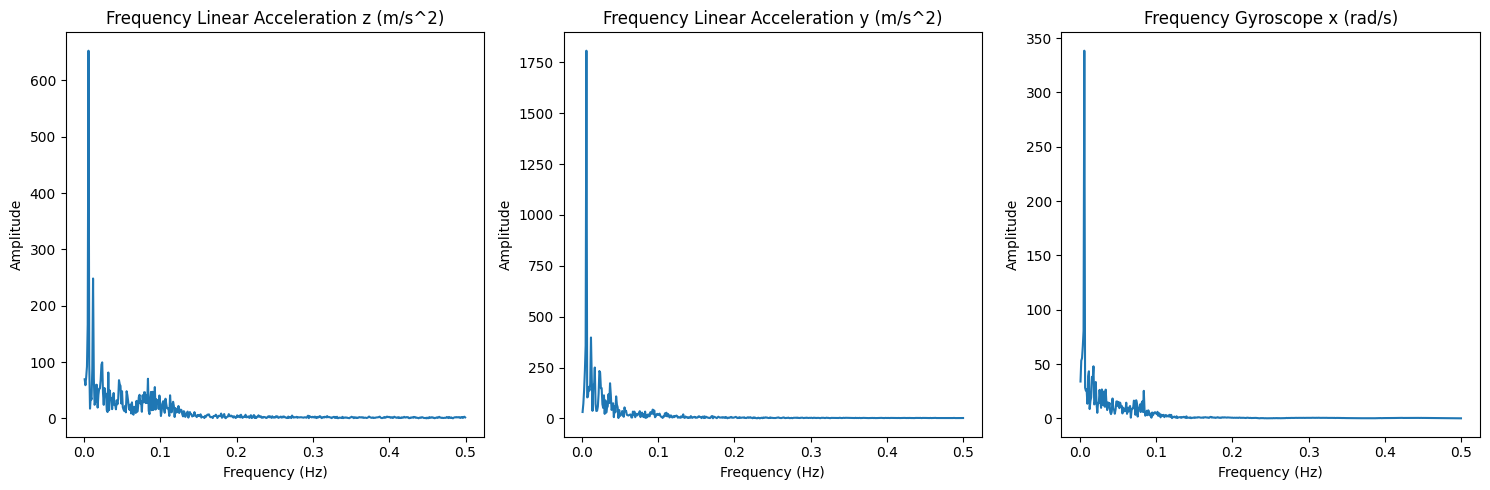

In [1376]:
plot_frequencies(squat_df)

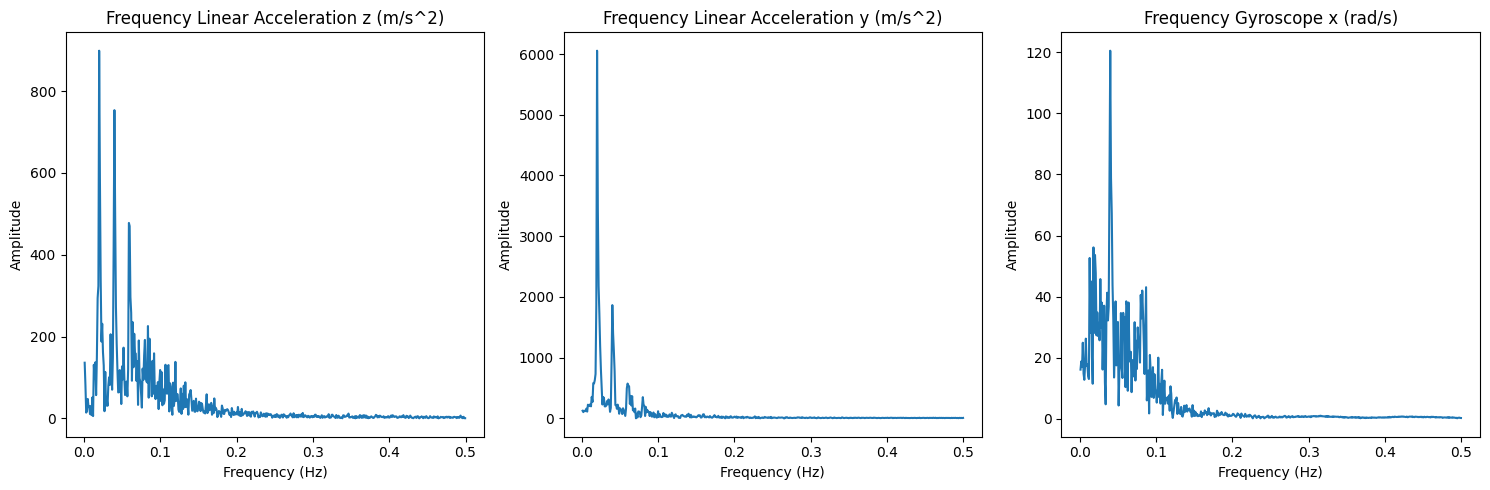

In [1377]:
plot_frequencies(jump_df)

### Filtern der Frequenzen

In den Plots ist erkennbar, dass der Großteil der Daten sich im Bereich bis 0,3 Hz befindet. Dies deutet darauf hin, dass 
die wesentlichen Bewegungsinformationen für Aktivitäten wie Kniebeugen und Sprünge in diesem niedrigen Frequenzbereich liegen.
Bei Kniebeugen und Sprüngen handelt es sich um relativ langsame Bewegungen, die durch größere, kontrollierte Muskelbewegungen
gekennzeichnet sind, im Gegensatz zu schnellen, feinen Bewegungen. Die niedrigeren Frequenzen repräsentieren diese langsameren,
großformatigen Bewegungen besser, während höhere Frequenzen tendenziell schnelle, kleine oder zufällige Bewegungen darstellen,
die möglicherweise als Rauschen betrachtet werden können.

In [1378]:
def filter_frequency(dataframe):
    # Kopie des DataFrames erstellen
    filtered_dataframe = dataframe.copy()

    # Festlegen der Cutoff-Frequenz und der Filterordnung
    filter_order = 4 
    high_cutoff = 0.3

    # Butterworth Hochpassfilter erstellen
    b, a = butter(filter_order, high_cutoff, btype='high', analog=False, fs=100)

    # Schleife über alle Spalten außer 'Time (s)'
    for column in dataframe.columns:
        if column != 'Time (s)':
            # Hochpassfilter auf die Signalreihe anwenden
            filtered_signal = filtfilt(b, a, dataframe[column])
            filtered_dataframe[column] = filtered_signal

    return filtered_dataframe

In [1379]:
filtered_df_sq = filter_frequency(squat_df)

In [1380]:
filtered_df_j = filter_frequency(jump_df)

In [1381]:
def plot_df(df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration y (m/s^2)'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration z (m/s^2)'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Gyroscope x (rad/s)'], marker=dict(size=4), name='Gyr X'), row=2, col=1)


    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

In [1382]:
def plot_normal_df(df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Y'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Z'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Gyr_X'], marker=dict(size=4), name='Gyr X'), row=2, col=1)


    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

Frequenz gefiltert

In [1383]:
plot_df(filtered_df_j)

In [1384]:
plot_df(filtered_df_sq)

In [1385]:
filtered_df_j_z = filtered_df_j.copy()
# Korrekte Spaltennamen verwenden
filtered_df_j_z['Z_Score_Y'] = stats.zscore(filtered_df_j['Linear Acceleration y (m/s^2)'])
filtered_df_j_z['Z_Score_Z'] = stats.zscore(filtered_df_j['Linear Acceleration z (m/s^2)'])
filtered_df_j_z['Z_Score_Gyr_X'] = stats.zscore(filtered_df_j['Gyroscope x (rad/s)']) 
print(filtered_df_j_z.head())

# Schwellenwert definieren
z_score_threshold = 3

# Ausreißer filtern
filtered_df_j_z = filtered_df_j_z[(abs(filtered_df_j_z['Z_Score_Gyr_X']) <= z_score_threshold) &
                                  (abs(filtered_df_j_z['Z_Score_Y']) <= z_score_threshold) &
                                  (abs(filtered_df_j_z['Z_Score_Z']) <= z_score_threshold)]


   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.014226                       1.155463                       1.423950   
1  0.024235                       1.145252                       3.481231   
2  0.034215                       1.092266                       5.339325   
3  0.044224                       1.534986                       6.876205   
4  0.054204                       2.060904                       8.011739   

   Gyroscope x (rad/s)  Z_Score_Y  Z_Score_Z  Z_Score_Gyr_X  
0            -0.217730   0.118320   0.365524      -0.450274  
1            -0.216169   0.277931   0.362208      -0.446900  
2            -0.214621   0.422088   0.344998      -0.443556  
3            -0.213087   0.541324   0.488792      -0.440242  
4            -0.211567   0.629422   0.659609      -0.436959  


In [1386]:
filtered_df_sq_z = filtered_df_sq.copy()
# Korrekte Spaltennamen verwenden
filtered_df_sq_z['Z_Score_Y'] = stats.zscore(filtered_df_sq['Linear Acceleration y (m/s^2)'])
filtered_df_sq_z['Z_Score_Z'] = stats.zscore(filtered_df_sq['Linear Acceleration z (m/s^2)'])
filtered_df_sq_z['Z_Score_Gyr_X'] = stats.zscore(filtered_df_sq['Gyroscope x (rad/s)']) 
print(filtered_df_sq_z.head())

# Schwellenwert definieren
z_score_threshold = 3

# Ausreißer filtern
filtered_df_sq_z = filtered_df_sq_z[(abs(filtered_df_sq_z['Z_Score_Gyr_X']) <= z_score_threshold) &
                                  (abs(filtered_df_sq_z['Z_Score_Y']) <= z_score_threshold) &
                                  (abs(filtered_df_sq_z['Z_Score_Z']) <= z_score_threshold)]


   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.014470                      -0.087995                       0.193291   
1  0.024510                      -0.110033                       0.037491   
2  0.034490                      -0.123475                      -0.094475   
3  0.044499                      -0.126524                      -0.135174   
4  0.054448                      -0.117025                      -0.065156   

   Gyroscope x (rad/s)  Z_Score_Y  Z_Score_Z  Z_Score_Gyr_X  
0             0.108063   0.074442  -0.073419       0.182567  
1             0.103144   0.019228  -0.092668       0.173532  
2             0.098214  -0.027539  -0.104410       0.164477  
3             0.093274  -0.041963  -0.107074       0.155403  
4             0.088323  -0.017149  -0.098776       0.146310  


Außreißer gefiltert

In [1387]:
plot_normal_df(filtered_df_sq_z)

In [1388]:
plot_normal_df(filtered_df_j_z)

In [1389]:
filtered_df_sq_z['Label'] = 'squat'
filtered_df_j_z['Label'] = 'jump'

max_time_squat = filtered_df_sq_z['Time (s)'].max()
filtered_df_j_z['Time (s)'] = filtered_df_j_z['Time (s)'] + max_time_squat

# DataFrames zusammenführen
combined_df = pd.concat([filtered_df_sq_z, filtered_df_j_z], ignore_index=True)


In [1390]:
combined_df.tail()

,Time (s),Linear Acceleration z (m/s^2),Linear Acceleration y (m/s^2),Gyroscope x (rad/s),Z_Score_Y,Z_Score_Z,Z_Score_Gyr_X,Label
1978,19.976952,2.296407,10.374795,-0.166578,0.812755,0.736100,-0.339763,jump
1979,19.986961,2.478821,9.682807,-0.041724,0.759069,0.795347,-0.070023,jump
1980,19.996941,2.533428,9.392571,0.089148,0.736551,0.813083,0.212719,jump
1981,20.006981,2.380244,9.471469,0.211668,0.742672,0.763330,0.477416,jump
1982,20.016930,2.193124,10.037822,0.303477,0.786612,0.702554,0.675765,jump


In [1391]:
combined_df.describe()

,Time (s),Linear Acceleration z (m/s^2),Linear Acceleration y (m/s^2),Gyroscope x (rad/s),Z_Score_Y,Z_Score_Z,Z_Score_Gyr_X
count,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000
mean,9.986018,-0.027361,-0.208816,-0.010391,-0.015692,-0.017380,-0.021580
std,5.784151,2.260109,9.212033,0.493497,0.989319,0.976811,0.970798
min,0.014470,-7.488487,-23.147904,-1.288004,-1.888835,-2.477660,-2.762542
25%,4.966039,-1.229659,-4.913331,-0.393411,-0.811408,-0.700023,-0.766841
50%,9.957658,-0.260591,-1.052773,-0.008710,-0.225494,-0.167799,-0.009049
75%,14.994848,1.059994,3.244179,0.411074,0.709906,0.603066,0.788534
max,20.016930,8.962896,30.362897,1.260967,2.662100,2.966359,2.744368


In [1392]:
plot_df(combined_df)

In [1393]:
combined_df.head()

,Time (s),Linear Acceleration z (m/s^2),Linear Acceleration y (m/s^2),Gyroscope x (rad/s),Z_Score_Y,Z_Score_Z,Z_Score_Gyr_X,Label
0,0.014470,-0.087995,0.193291,0.108063,0.074442,-0.073419,0.182567,squat
1,0.024510,-0.110033,0.037491,0.103144,0.019228,-0.092668,0.173532,squat
2,0.034490,-0.123475,-0.094475,0.098214,-0.027539,-0.104410,0.164477,squat
3,0.044499,-0.126524,-0.135174,0.093274,-0.041963,-0.107074,0.155403,squat
4,0.054448,-0.117025,-0.065156,0.088323,-0.017149,-0.098776,0.146310,squat


In [1394]:
windows = []
labels = []
window_size = 100
overlap = 50

for i in range(0, len(combined_df), window_size - overlap):
    window = combined_df.iloc[i:i+window_size]
    windows.append(window)
    labels.append(window.iloc[0]['Label'])

# Erstelle den Label DataFrame
label_df = pd.DataFrame(labels, columns=['Label'])

#Ersten Dataframe in der Liste ausgeben lassen 
print(windows[0].head())
#Anzahl Datenpunkte des ersten Dataframes ausgeben lassen 
print(len(windows[0]))
#Spalten des ersten Dataframes ausgeben lassen 
#print(windows[0].columns)

#Ausgeben lassen wie viele Dataframes also Fenster entstanden sind 
print (len(windows))


   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.014470                      -0.087995                       0.193291   
1  0.024510                      -0.110033                       0.037491   
2  0.034490                      -0.123475                      -0.094475   
3  0.044499                      -0.126524                      -0.135174   
4  0.054448                      -0.117025                      -0.065156   

   Gyroscope x (rad/s)  Z_Score_Y  Z_Score_Z  Z_Score_Gyr_X  Label  
0             0.108063   0.074442  -0.073419       0.182567  squat  
1             0.103144   0.019228  -0.092668       0.173532  squat  
2             0.098214  -0.027539  -0.104410       0.164477  squat  
3             0.093274  -0.041963  -0.107074       0.155403  squat  
4             0.088323  -0.017149  -0.098776       0.146310  squat  
100
40


In [1395]:
windows[0].head()

,Time (s),Linear Acceleration z (m/s^2),Linear Acceleration y (m/s^2),Gyroscope x (rad/s),Z_Score_Y,Z_Score_Z,Z_Score_Gyr_X,Label
0,0.014470,-0.087995,0.193291,0.108063,0.074442,-0.073419,0.182567,squat
1,0.024510,-0.110033,0.037491,0.103144,0.019228,-0.092668,0.173532,squat
2,0.034490,-0.123475,-0.094475,0.098214,-0.027539,-0.104410,0.164477,squat
3,0.044499,-0.126524,-0.135174,0.093274,-0.041963,-0.107074,0.155403,squat
4,0.054448,-0.117025,-0.065156,0.088323,-0.017149,-0.098776,0.146310,squat


In [1396]:
# Leere Liste erstellen, um Features zu speichern
feature_list = []

# Jeden DataFrame in windows einzeln durchgehen und für jede der drei Achsen die Features berechnen
for window in windows:
    acc_y = window['Z_Score_Y']
    acc_z = window['Z_Score_Z']
    gyro_x = window['Z_Score_Gyr_X']

    # Berechnete Werte an Liste anhängen, unter entsprechend benannten Spalten
    features = {
        'acc_y_peak': acc_y.max(),
        'acc_y_std_dev': acc_y.std(),
        'acc_y_variance': acc_y.var(),
        'acc_y_signal_energy': np.sum(acc_y**2),
        'acc_z_peak': acc_z.max(),
        'acc_z_std_dev': acc_z.std(),
        'acc_z_variance': acc_z.var(),
        'acc_z_signal_energy': np.sum(acc_z**2),
        'gyro_x_peak': gyro_x.max(),
        'gyro_x_std_dev': gyro_x.std(),
        'gyro_x_variance': gyro_x.var(),
        'gyro_x_signal_energy': np.sum(gyro_x**2)
    }
    feature_list.append(features)

feature_df = pd.DataFrame(feature_list)

print(feature_df.head())


   acc_y_peak  acc_y_std_dev  acc_y_variance  acc_y_signal_energy  acc_z_peak  \
0    0.350426       0.536852        0.288210            42.749511    1.229798   
1    1.684204       0.927098        0.859511            85.126653    1.409212   
2    1.836614       0.673160        0.453144            89.860130    1.710505   
3    1.836614       1.046718        1.095618           118.896547    1.710505   
4    1.257206       0.856712        0.733955           102.958004    1.906206   

   acc_z_std_dev  acc_z_variance  acc_z_signal_energy  gyro_x_peak  \
0       0.544597        0.296585            34.985631     1.196949   
1       0.837787        0.701886            71.097156     0.368720   
2       0.690799        0.477204            69.960243     1.665818   
3       0.778709        0.606388            65.291430     1.665818   
4       0.769535        0.592185            79.711465     0.983517   

   gyro_x_std_dev  gyro_x_variance  gyro_x_signal_energy  
0        0.730227         0.53323

Genauigkeit: 0.75
Konfusionsmatrix:
 [[4 1]
 [2 5]]
Klassifikationsreport:
               precision    recall  f1-score   support

        jump       0.67      0.80      0.73         5
       squat       0.83      0.71      0.77         7

    accuracy                           0.75        12
   macro avg       0.75      0.76      0.75        12
weighted avg       0.76      0.75      0.75        12



[Text(0.5, 0.875, 'x[0] <= 1.909\ngini = 0.497\nsamples = 28\nvalue = [15, 13]'),
 Text(0.25, 0.625, 'x[8] <= 2.311\ngini = 0.165\nsamples = 11\nvalue = [1, 10]'),
 Text(0.125, 0.375, 'gini = 0.0\nsamples = 10\nvalue = [0, 10]'),
 Text(0.375, 0.375, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.75, 0.625, 'x[4] <= 2.918\ngini = 0.291\nsamples = 17\nvalue = [14, 3]'),
 Text(0.625, 0.375, 'x[0] <= 2.366\ngini = 0.124\nsamples = 15\nvalue = [14, 1]'),
 Text(0.5, 0.125, 'gini = 0.0\nsamples = 14\nvalue = [14, 0]'),
 Text(0.75, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.875, 0.375, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]')]

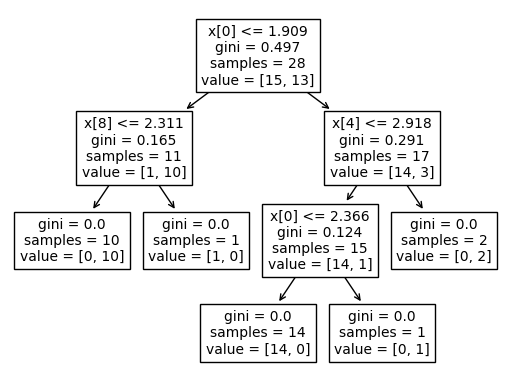

In [1397]:
from sklearn.metrics import classification_report, confusion_matrix


X = feature_df
y = label_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Modell testen
y_pred = clf.predict(X_test)

# Modell auswerten
print("Genauigkeit:", accuracy_score(y_test, y_pred))
print("Konfusionsmatrix:\n", confusion_matrix(y_test, y_pred))
print("Klassifikationsreport:\n", classification_report(y_test, y_pred))

# Baum visualisieren (optional)
plot_tree(clf)






Clustering

In [1398]:
from sklearn.cluster import KMeans

# Anzahl der gewünschten Cluster festlegen 
anzahl_cluster = 2  # Passe dies an deine Anforderungen an.

# Initialisierung des K-Means-Cluster-Algorithmus
kmeans = KMeans(n_clusters=anzahl_cluster, random_state=0)

# Clustering auf den Daten in 'feature_df' durchführen
cluster_labels = kmeans.fit_predict(feature_df)

# Berechnete Cluster zu jedem der Datenpunkte im Feature Dataframe zuordnungen
feature_df['Cluster'] = cluster_labels

# Gib das aktualisierte DataFrame mit Clusterzuordnungen aus.
#print(feature_df.head())
feature_df.columns


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Index(['acc_y_peak', 'acc_y_std_dev', 'acc_y_variance', 'acc_y_signal_energy',
       'acc_z_peak', 'acc_z_std_dev', 'acc_z_variance', 'acc_z_signal_energy',
       'gyro_x_peak', 'gyro_x_std_dev', 'gyro_x_variance',
       'gyro_x_signal_energy', 'Cluster'],
      dtype='object')

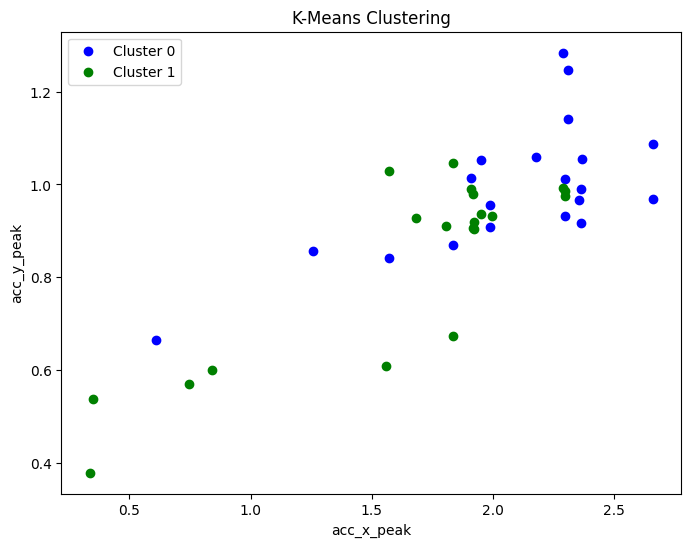

In [1399]:
# Visualisierung der Cluster
plt.figure(figsize=(8, 6))

# Erstelle eine Liste von Farben für die Cluster
farben = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Durchlaufen der Cluster und erstellen der Scatter-Plots für jeden Cluster
for cluster_id in range(anzahl_cluster):
    cluster_data = feature_df[feature_df['Cluster'] == cluster_id]
    plt.scatter(cluster_data['acc_y_peak'], cluster_data['acc_y_std_dev'], c=farben[cluster_id], label=f'Cluster {cluster_id}')
# Beschriftung des Diagramms
plt.xlabel('acc_x_peak')
plt.ylabel('acc_y_peak')
plt.title('K-Means Clustering')
plt.legend()

# Anzeigen des Scatter-Plots
plt.show()
